In [48]:
import pandas as pd
import xarray as xr
import matplotlib.pyplot as plt
import numpy as np

In [2]:
!ls pyWake/

pywake_FUGA.nc        pywake_linear_bast.nc


In [3]:
!ls foxes/

power_validation_inputs_foxes_A.csv
power_validation_inputs_foxes_B.csv
power_validation_inputs_foxes_C.csv
power_validation_inputs_foxes_D.csv
power_validation_inputs_foxes_E.csv
power_validation_inputs_foxes_F.csv
power_validation_inputs_foxes_G.csv
turbine_data_validation_inputs_foxes_A.nc
turbine_data_validation_inputs_foxes_B.nc
turbine_data_validation_inputs_foxes_C.nc
turbine_data_validation_inputs_foxes_D.nc
turbine_data_validation_inputs_foxes_E.nc
turbine_data_validation_inputs_foxes_F.nc
turbine_data_validation_inputs_foxes_G.nc


In [4]:
!ls WAYVE/

power_windio_les_validation_wayve.csv


In [6]:
pywake_no_blockage = xr.load_dataset('pyWake/pywake_linear_bast.nc')
pywake_blockage = xr.load_dataset('pyWake/pywake_FUGA.nc')

In [10]:
letters = ['A', 'B', 'C', 'D', 'E', 'F', 'G']
foxes_pred = [xr.load_dataset('foxes/turbine_data_validation_inputs_foxes_%s.nc' % letters[ii]) for ii in range(len(letters))]

In [31]:
wayve_dat = pd.read_csv('WAYVE/power_windio_les_validation_wayve.csv')

In [62]:
np.array([wayve_dat.iloc[0].values[1:].max(), 1e3 * foxes_pred[0].isel(state=0).P.values.max(),  pywake_no_blockage.isel(time=0).Power.values.max()]) / 1e6

array([ 9.19739901, 10.60773503,  9.56215049])

ok


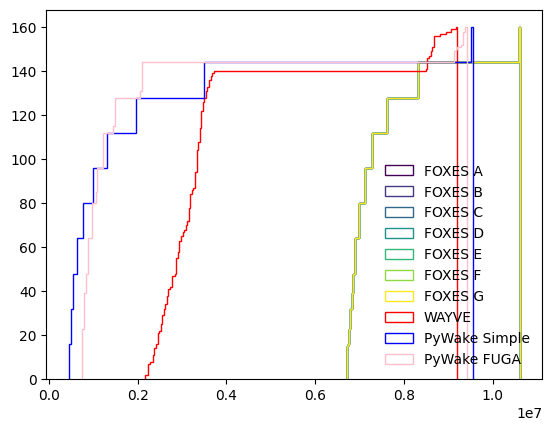

In [65]:
foxes_colors = plt.cm.viridis(np.linspace(0, 1, len(letters)))

for ll in range(len(letters)):
    plt.hist(foxes_pred[0].isel(state=0).P * 1e3, 200, cumulative=True, histtype='step', edgecolor=foxes_colors[ll], label='FOXES %s' % letters[ll])
plt.hist(wayve_dat.iloc[0].values[1:], 200, cumulative=True, histtype='step', edgecolor='red', label='WAYVE')
plt.hist(pywake_no_blockage.isel(time=0).Power, 200, cumulative=True, histtype='step', edgecolor='blue', label='PyWake Simple')
plt.hist(pywake_blockage.isel(time=0).Power, 200, cumulative=True, histtype='step', edgecolor='pink', label='PyWake FUGA')
plt.legend()
print('ok')